# Federated Mnist tests

Setup:
- 9 clusters with 1000 training images and 1000 test images (heterogeneously distributed) from mnist
- variable number of users for each cluster (chosen in the following code)
- in each communication round, all the users are active 
- each users has got a classification model
- each cluster has got a classification model
- in each communication round, some sort of aggregation is performed at the cluster level, then each cluster communicates with the server
- at the server side there are some data (homogeneously distributed, i.e. uniformly taken from the original mnist dataset) to perform a smart aggregation

Note:
- the distributed environment is simulated
- the performance can be measured in terms of local accuracy or global accuracy, on cluster test set or server-side test set

Author: Nicola Gulmini (nicolagulmini@gmail.com)

# Modules and parameters

In [1]:
!rm -r federated_learning
!git clone git://github.com/nicolagulmini/federated_learning

rm: cannot remove 'federated_learning': No such file or directory
Cloning into 'federated_learning'...
remote: Enumerating objects: 53266, done.
remote: Counting objects: 100% (10400/10400), done.
remote: Compressing objects: 100% (10323/10323), done.
remote: Total 53266 (delta 405), reused 9929 (delta 76), pack-reused 42866
Receiving objects: 100% (53266/53266), 37.04 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (569/569), done.
Checking out files: 100% (54063/54063), done.


In [2]:
# from github
from federated_learning.utils import *
from federated_learning.aggregator import *

# other libraries
from tensorflow.keras import models
from skimage import io
from skimage import transform
import pandas as pd
from numpy import array
from numpy import argmax
from numpy import swapaxes
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from random import choice

In [3]:
# PARAMETERS
number_of_users = 45
number_of_clusters = 9 # according to the stored federated_mnist dataset

# local_epochs = 4 # default in federated setup class
# local_batch = 16 # default in federated setup class
communication_rounds = 200
TRAINED = True

# Initialization of the setup and the datasets

In [4]:
# definition of the setup with the central server and its datasets
server = server()
server.model = define_model_mnist().model
fed_setup = federated_setup(server)
fed_setup.server_side_dataset_generator(600, 200)

11501568/11490434 [==============================] - 0s 0us/step
Server dataset setting completed.


In [5]:
# initialization of the clusters with the users assigned. This is the method that creates the setup, returning a list of clusters with no data
clusters = fed_setup.initialize_users_to_clusters(number_of_users, number_of_clusters)

Cluster number 0. User ids: [0, 1, 2, 3, 4]
Cluster number 1. User ids: [5, 6, 7, 8, 9]
Cluster number 2. User ids: [10, 11, 12, 13, 14]
Cluster number 3. User ids: [15, 16, 17, 18, 19]
Cluster number 4. User ids: [20, 21, 22, 23, 24]
Cluster number 5. User ids: [25, 26, 27, 28, 29]
Cluster number 6. User ids: [30, 31, 32, 33, 34]
Cluster number 7. User ids: [35, 36, 37, 38, 39]
Cluster number 8. User ids: [40, 41, 42, 43, 44]


Dataset load, rotating some images to make the learning more challenging

In [6]:
# take the images and the .csv labels from the dataset to numpy arrays
# note that the same process could be done with cifar10 (soon...)
clusters_train_data, clusters_test_data = [], []
datapath = "federated_learning/federated_mnist/federated_mnist_80/"
for i in range(number_of_clusters):
    cluster_data_path = datapath + str(i)
    train_path = cluster_data_path + "/training_images/"
    test_path = cluster_data_path + "/test_images/"
    ytrain = pd.read_csv(cluster_data_path + "/training_labels.csv", header=None, usecols=[1]).to_numpy().reshape(-1)
    ytest = pd.read_csv(cluster_data_path + "/test_labels.csv", header=None, usecols=[1]).to_numpy().reshape(-1)
    xtrain, xtest = [], []
    for img in range(len(ytrain)):
        xtrain.append(transform.rotate(io.imread(train_path + str(img) + ".png", as_gray=True), choice([0, 90, 180, 270])))
    for img in range(len(ytest)):
        xtest.append(transform.rotate(io.imread(test_path + str(img) + ".png", as_gray=True), choice([0, 90, 180, 270])))
    xtrain = array(xtrain)
    xtest = array(xtest)
    ytrain = array(ytrain)
    ytest = array(ytest)
    clusters_train_data.append({'cluster': i, 'images': xtrain, 'labels': ytrain})
    clusters_test_data.append({'cluster': i, 'images': xtest, 'labels': ytest})

In [7]:
# these methods assign data from the just loaded dataset to the clusters, and then from each cluster to its users
fed_setup.assign_dataset_to_clusters(clusters_train_data, clusters_test_data)
fed_setup.assign_clusters_data_to_users(verbose=0)

# initialize clusters models
for cluster in fed_setup.list_of_clusters:
    cluster.initialize_models()
    for user in cluster.users:
        user.initialize_classification_model()
    # then to transfer the cluster model to its users the transfer_cluster_model_to_users() method has to be used

# propagate from server to clusters the initial classification model
fed_setup.server_to_cluster_classification() # useless if local_updates=True then

Set data for cluster 0
Set data for cluster 1
Set data for cluster 2
Set data for cluster 3
Set data for cluster 4
Set data for cluster 5
Set data for cluster 6
Set data for cluster 7
Set data for cluster 8
Done.


In [8]:
if not TRAINED:
    # to plot
    #server_aggregator_performance = []
    genie_perf = [fed_setup.genie()]
    #local_acc = []
    global_avg_softmax = [fed_setup.global_acc_of_avg_softmax_model()]
    server_global_acc = [fed_setup.server.model.evaluate(fed_setup.server.x_test, fed_setup.server.y_test, verbose=0)[1]]
    server_avg_local_acc = []
    avg_local_local_models = []
    avg_local_avg_softmax = [fed_setup.avg_softmax_on_local_datasets()]

    # other metrics
    tmp_server_local_acc = 0
    tmp_acc = 0
    for cluster in fed_setup.list_of_clusters:
        tmp_server_local_acc += fed_setup.server.model.evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
        tmp_acc += cluster.get_model().evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
    server_avg_local_acc.append(tmp_server_local_acc/len(fed_setup.list_of_clusters))
    avg_local_local_models.append(tmp_acc/len(fed_setup.list_of_clusters))

    # training
    print("\nStart training.\n")
    for round in range(communication_rounds):

        print("\n****** COMMUNICATION ROUND NUMBER " + str(round) + " START ******\n")
        # train
        avg_local_local_models_acc, tmp_server_global_acc = fed_setup.clustered_fed_avg_one_shot(local_updates=False)

        # returned metrics
        server_global_acc.append(tmp_server_global_acc)
        avg_local_local_models.append(avg_local_local_models_acc)

        # other metrics
        genie_perf.append(fed_setup.genie())
        global_avg_softmax.append(fed_setup.global_acc_of_avg_softmax_model())
        avg_local_avg_softmax.append(fed_setup.avg_softmax_on_local_datasets())

        # server model local performances
        tmp_server_local_acc = 0
        for cluster in fed_setup.list_of_clusters:
            tmp_server_local_acc += fed_setup.server.model.evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
        server_avg_local_acc.append(tmp_server_local_acc/len(fed_setup.list_of_clusters))

else:
    # load already trained models
    for cluster in fed_setup.list_of_clusters:
        cluster.model = models.load_model("./federated_learning/federated_mnist/200_rounds_80_heterogeneity_trained_local_models/200rounds_cluster_model_"+str(cluster.number)+".h5")

In [11]:
# define the aggregator
# Attention based aggregator
server_agg = attention_based_aggregator(len(fed_setup.list_of_clusters))

(x_train, y_train), (x_val, y_val), (x_test, y_test) = server_agg.produce_datasets(fed_setup)
epochs = 20
server_agg_acc, server_agg_loss, server_agg_val_acc, server_agg_val_loss = server_agg.train(x_train, y_train, x_val, y_val, 0, epochs)
server_acc = server_agg.evaluate(x_test, y_test, 0)

# Plot performance

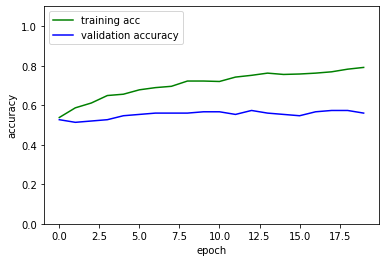

In [13]:
plt.figure()
plt.plot(range(epochs), server_agg_acc, label='training acc', color='green')
plt.plot(range(epochs), server_agg_val_acc, label='validation accuracy', color='blue')

plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("accuracy")
#plt.xlim(0, server_epochs+1)
plt.ylim(0, 1.1)
plt.savefig('server_aggregator_acc.png')

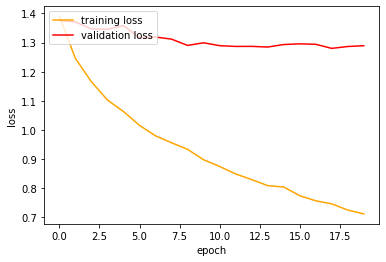

In [14]:
plt.figure()
plt.plot(range(epochs), server_agg_loss, label='training loss', color='orange')
plt.plot(range(epochs), server_agg_val_loss, label='validation loss', color='red')

plt.legend(loc="upper left")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.xlim(-.5, server_epochs+1)
plt.savefig('server_aggregator_loss.png')

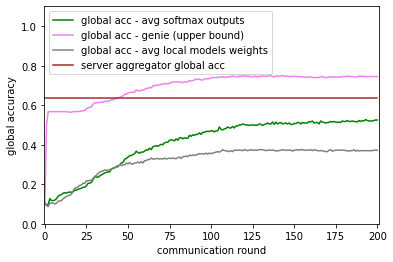

In [15]:
communication_rounds = 200
plt.figure()
plt.plot(range(communication_rounds+1), [0.105, 0.0925, 0.1, 0.1275, 0.1175, 0.1175, 0.12, 0.1275, 0.14, 0.145, 0.1475, 0.155, 0.1575, 0.155, 0.16, 0.16, 0.16, 0.1625, 0.17, 0.17, 0.175, 0.1775, 0.18, 0.185, 0.185, 0.1925, 0.205, 0.205, 0.21, 0.225, 0.2375, 0.2375, 0.235, 0.2425, 0.2475, 0.2525, 0.2575, 0.26, 0.2625, 0.2625, 0.2775, 0.28, 0.2825, 0.29, 0.2925, 0.2975, 0.3075, 0.31, 0.3275, 0.33, 0.3375, 0.345, 0.345, 0.35, 0.355, 0.3675, 0.36, 0.3575, 0.3625, 0.3625, 0.3675, 0.375, 0.3725, 0.3825, 0.375, 0.39, 0.3925, 0.395, 0.3925, 0.3975, 0.4025, 0.4, 0.41, 0.4125, 0.4125, 0.4225, 0.425, 0.4225, 0.42, 0.43, 0.4225, 0.435, 0.435, 0.43, 0.435, 0.4325, 0.4325, 0.4475, 0.4425, 0.45, 0.4475, 0.4525, 0.4525, 0.46, 0.4525, 0.4625, 0.4625, 0.4675, 0.4675, 0.4675, 0.47, 0.47, 0.465, 0.47, 0.47, 0.49, 0.4775, 0.475, 0.48, 0.4825, 0.49, 0.485, 0.485, 0.4925, 0.485, 0.495, 0.495, 0.5, 0.5, 0.505, 0.5025, 0.5, 0.5, 0.4975, 0.5, 0.5, 0.5, 0.4975, 0.5, 0.505, 0.5025, 0.4975, 0.5025, 0.505, 0.51, 0.505, 0.505, 0.515, 0.5025, 0.515, 0.505, 0.51, 0.5125, 0.505, 0.5075, 0.51, 0.505, 0.51, 0.5025, 0.5025, 0.5075, 0.5075, 0.5125, 0.5125, 0.505, 0.5125, 0.51, 0.51, 0.51, 0.5175, 0.515, 0.52, 0.51, 0.5125, 0.5125, 0.505, 0.52, 0.515, 0.5125, 0.51, 0.5125, 0.5125, 0.5175, 0.515, 0.5175, 0.515, 0.5125, 0.515, 0.5125, 0.52, 0.5175, 0.5175, 0.5225, 0.5175, 0.5175, 0.52, 0.5175, 0.5175, 0.515, 0.5225, 0.5175, 0.5225, 0.52, 0.5275, 0.5225, 0.52, 0.52, 0.52, 0.5225, 0.525, 0.525], label='global acc - avg softmax outputs', color='green')
plt.plot(range(communication_rounds+1), [0.105, 0.505, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.5675, 0.565, 0.565, 0.565, 0.5675, 0.5675, 0.5675, 0.5675, 0.57, 0.57, 0.5725, 0.5725, 0.5825, 0.5875, 0.5875, 0.5925, 0.605, 0.6125, 0.6125, 0.6125, 0.615, 0.615, 0.615, 0.62, 0.62, 0.62, 0.6225, 0.6275, 0.6275, 0.63, 0.635, 0.635, 0.64, 0.6425, 0.6475, 0.655, 0.655, 0.6625, 0.665, 0.665, 0.665, 0.6675, 0.6775, 0.6725, 0.6725, 0.675, 0.6775, 0.68, 0.685, 0.685, 0.69, 0.6875, 0.6975, 0.7, 0.7, 0.7025, 0.7025, 0.705, 0.7075, 0.7075, 0.71, 0.7075, 0.71, 0.715, 0.7175, 0.7175, 0.7175, 0.7175, 0.7175, 0.715, 0.715, 0.7175, 0.7175, 0.7175, 0.725, 0.7225, 0.725, 0.7275, 0.7325, 0.73, 0.7325, 0.7275, 0.7275, 0.7325, 0.735, 0.7325, 0.735, 0.7375, 0.74, 0.74, 0.74, 0.74, 0.7425, 0.7425, 0.7425, 0.7425, 0.74, 0.745, 0.7425, 0.745, 0.7475, 0.745, 0.745, 0.7425, 0.7475, 0.745, 0.75, 0.745, 0.75, 0.745, 0.7475, 0.7425, 0.745, 0.745, 0.7475, 0.7425, 0.7475, 0.745, 0.7475, 0.7475, 0.745, 0.7475, 0.75, 0.75, 0.745, 0.7425, 0.7475, 0.7475, 0.745, 0.7475, 0.75, 0.7475, 0.745, 0.7475, 0.745, 0.745, 0.745, 0.7475, 0.745, 0.745, 0.745, 0.7425, 0.745, 0.7425, 0.74, 0.7425, 0.7425, 0.7425, 0.74, 0.74, 0.74, 0.74, 0.74, 0.745, 0.745, 0.74, 0.74, 0.74, 0.7425, 0.745, 0.7425, 0.7425, 0.7425, 0.7425, 0.7425, 0.7425, 0.745, 0.745, 0.745, 0.7475, 0.745, 0.745, 0.745, 0.7425, 0.745, 0.7425, 0.7475, 0.745, 0.7475, 0.745, 0.745, 0.745, 0.745, 0.745, 0.745, 0.745, 0.745, 0.745], label='global acc - genie (upper bound)', color='violet')
plt.plot(range(communication_rounds+1), [0.10499999672174454, 0.0925000011920929, 0.08749999850988388, 0.10499999672174454, 0.10499999672174454, 0.10499999672174454, 0.10000000149011612, 0.10499999672174454, 0.11500000208616257, 0.11500000208616257, 0.11749999970197678, 0.1274999976158142, 0.13249999284744263, 0.13750000298023224, 0.14249999821186066, 0.14499999582767487, 0.15000000596046448, 0.16750000417232513, 0.18000000715255737, 0.18250000476837158, 0.1875, 0.19499999284744263, 0.19750000536441803, 0.20499999821186066, 0.20499999821186066, 0.2175000011920929, 0.2175000011920929, 0.2199999988079071, 0.2199999988079071, 0.23000000417232513, 0.23999999463558197, 0.24500000476837158, 0.2549999952316284, 0.26249998807907104, 0.26499998569488525, 0.26750001311302185, 0.27250000834465027, 0.27000001072883606, 0.27250000834465027, 0.27250000834465027, 0.2775000035762787, 0.2824999988079071, 0.2849999964237213, 0.2874999940395355, 0.2874999940395355, 0.30000001192092896, 0.29499998688697815, 0.29750001430511475, 0.29750001430511475, 0.3075000047683716, 0.30250000953674316, 0.3100000023841858, 0.30250000953674316, 0.30250000953674316, 0.3075000047683716, 0.3075000047683716, 0.3125, 0.3075000047683716, 0.3149999976158142, 0.3075000047683716, 0.3199999928474426, 0.3199999928474426, 0.32499998807907104, 0.32499998807907104, 0.33250001072883606, 0.32749998569488525, 0.32749998569488525, 0.33000001311302185, 0.33000001311302185, 0.32749998569488525, 0.33000001311302185, 0.32749998569488525, 0.33250001072883606, 0.32749998569488525, 0.33000001311302185, 0.33250001072883606, 0.33000001311302185, 0.33250001072883606, 0.33000001311302185, 0.33000001311302185, 0.33500000834465027, 0.3375000059604645, 0.33000001311302185, 0.3400000035762787, 0.3400000035762787, 0.3425000011920929, 0.3400000035762787, 0.3474999964237213, 0.3449999988079071, 0.3474999964237213, 0.3474999964237213, 0.3474999964237213, 0.35249999165534973, 0.35499998927116394, 0.35249999165534973, 0.35499998927116394, 0.35249999165534973, 0.35749998688697815, 0.35249999165534973, 0.35749998688697815, 0.35499998927116394, 0.35749998688697815, 0.36000001430511475, 0.36250001192092896, 0.36500000953674316, 0.36250001192092896, 0.3675000071525574, 0.375, 0.3700000047683716, 0.3700000047683716, 0.3675000071525574, 0.36500000953674316, 0.3700000047683716, 0.36500000953674316, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3700000047683716, 0.375, 0.3725000023841858, 0.3700000047683716, 0.3725000023841858, 0.375, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.375, 0.375, 0.375, 0.3725000023841858, 0.3700000047683716, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3675000071525574, 0.3700000047683716, 0.3700000047683716, 0.3725000023841858, 0.375, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3675000071525574, 0.3725000023841858, 0.3725000023841858, 0.375, 0.3725000023841858, 0.375, 0.375, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.375, 0.3700000047683716, 0.375, 0.3725000023841858, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3675000071525574, 0.36500000953674316, 0.36500000953674316, 0.3725000023841858, 0.375, 0.3675000071525574, 0.3700000047683716, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858, 0.3700000047683716, 0.3700000047683716, 0.3675000071525574, 0.3700000047683716, 0.3700000047683716, 0.375, 0.3675000071525574, 0.3725000023841858, 0.3675000071525574, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3700000047683716, 0.3725000023841858, 0.3725000023841858, 0.3725000023841858], label='global acc - avg local models weights', color='grey')
plt.plot(range(communication_rounds+1), [server_acc for _ in range(communication_rounds+1)], label='server aggregator global acc', color='brown')

plt.legend(loc="upper left")
plt.xlabel("communication round")
plt.ylabel("global accuracy")
plt.xlim(-.5, communication_rounds+1)
plt.ylim(0, 1.1)
plt.savefig('global.png')

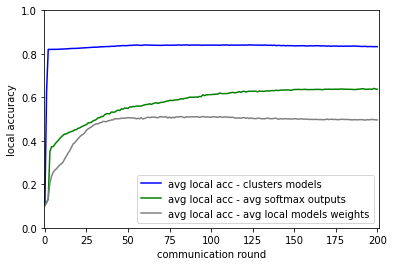

In [16]:
plt.figure()

plt.plot(range(communication_rounds+1), [0.10310310353007582, 0.6275163971715503, 0.8204871416091919, 0.8204871416091919, 0.8204871416091919, 0.8204871416091919, 0.8205983638763428, 0.8207095861434937, 0.8210432529449463, 0.8211544752120972, 0.8214881420135498, 0.8221554756164551, 0.8224891424179077, 0.8226003646850586, 0.8233789205551147, 0.8243799209594727, 0.8247135877609253, 0.8250472545623779, 0.8248248100280762, 0.8252696990966797, 0.8256033658981323, 0.8263819217681885, 0.8267155885696411, 0.8272716999053955, 0.8278278112411499, 0.8280502557754517, 0.8287175893783569, 0.8293849229812622, 0.8297185897827148, 0.8302747011184692, 0.8307195901870728, 0.8303859233856201, 0.831386923789978, 0.8317205905914307, 0.8327215909957886, 0.8324991464614868, 0.833277702331543, 0.8336113691329956, 0.8335001468658447, 0.8339450359344482, 0.8343899250030518, 0.8349460495842826, 0.8347236050499809, 0.8360582722557914, 0.8368368281258476, 0.8366143835915458, 0.8372817171944511, 0.8381714953316581, 0.8375041617287529, 0.8380602730645073, 0.8378378285302055, 0.8392837180031669, 0.8388388223118253, 0.8398398293389213, 0.8400622738732231, 0.8401735027631123, 0.8405071629418266, 0.8390612734688652, 0.8390612734688652, 0.8401735027631123, 0.8408408297432792, 0.8403959472974141, 0.8397286070717704, 0.8399510516060722, 0.840507169564565, 0.8397286203172472, 0.839506169160207, 0.8397286203172472, 0.8387276000446742, 0.8390612734688654, 0.8389500445789762, 0.8392837180031671, 0.839394940270318, 0.8401734961403742, 0.8396173914273579, 0.839506169160207, 0.8402847250302632, 0.8395061625374687, 0.8401735027631123, 0.8398398293389213, 0.8411745097902086, 0.8403959472974141, 0.8399510582288106, 0.8406183852089777, 0.8403959472974141, 0.8408408297432794, 0.8410632742775812, 0.8395061559147305, 0.8406183852089775, 0.8400622738732233, 0.8406183785862393, 0.8403959406746759, 0.8406183852089777, 0.8405071629418268, 0.8398398359616597, 0.8392837180031671, 0.8402847184075248, 0.8399510516060724, 0.840284718407525, 0.8405071629418268, 0.8399510449833341, 0.8397286070717707, 0.8405071629418268, 0.8397286004490323, 0.8403959274291992, 0.8391724824905396, 0.8406183852089777, 0.8408408297432792, 0.8405071563190885, 0.8409520520104301, 0.8406183785862393, 0.8396173848046196, 0.84072960085339, 0.840173496140374, 0.8406183785862391, 0.8398398160934448, 0.8402847184075248, 0.8399510449833338, 0.8399510449833341, 0.8406183918317158, 0.8399510516060722, 0.8409520586331685, 0.8398398293389213, 0.8415081699689229, 0.8406183852089775, 0.8409520586331685, 0.8402847117847867, 0.8403959406746759, 0.8401734895176358, 0.8401734961403742, 0.8399510582288106, 0.8396173848046198, 0.8406183852089777, 0.8398398293389215, 0.8392837113804288, 0.8397286004490323, 0.8399510449833341, 0.8383939266204834, 0.8401734895176358, 0.8383939266204834, 0.8381714820861816, 0.8391724891132779, 0.8376153707504272, 0.8380602598190308, 0.8383939266204834, 0.836948037147522, 0.8381714820861816, 0.8372817039489746, 0.837837815284729, 0.8373929262161255, 0.8373929262161255, 0.8363919258117676, 0.8372817039489746, 0.8373929262161255, 0.8372817039489746, 0.8376153707504272, 0.8373929262161255, 0.8360582590103149, 0.8365031480789185, 0.8365031480789185, 0.836948037147522, 0.8367255926132202, 0.8366143703460693, 0.8375041484832764, 0.8375041484832764, 0.8372817039489746, 0.8363919258117676, 0.8368368148803711, 0.8362807035446167, 0.8359470367431641, 0.8356133699417114, 0.8361694812774658, 0.835057258605957, 0.8358358144760132, 0.8359470367431641, 0.8356133699417114, 0.8357245922088623, 0.8346123695373535, 0.8356133699417114, 0.835057258605957, 0.8353909254074097, 0.8353909254074097, 0.8351684808731079, 0.8359470367431641, 0.8351684808731079, 0.8355021476745605, 0.8361694812774658, 0.8355021476745605, 0.8352797031402588, 0.8346123695373535, 0.8340562582015991, 0.8339450359344482, 0.8342787027359009, 0.8343899250030518, 0.8331664800643921, 0.8337225914001465, 0.8338338136672974, 0.8331664800643921, 0.8330552577972412, 0.833277702331543, 0.8331664800643921], label='avg local acc - clusters models', color='blue')
plt.plot(range(communication_rounds+1), [0.1031031031031031, 0.116894672450228, 0.13113113113113115, 0.3511289066844622, 0.37292848403959517, 0.37326215103992877, 0.3844956067178289, 0.3938382827271716, 0.4020687354020687, 0.4113001890779669, 0.4184184184184184, 0.4260927594260928, 0.4313202090979869, 0.4319875430986543, 0.4372149927705483, 0.4397731064397731, 0.4431097764431098, 0.4454454454454454, 0.4511177844511178, 0.45156267378489606, 0.4574574574574575, 0.45968190412634846, 0.4647981314647981, 0.46791235680124577, 0.47180513847180516, 0.4748081414748081, 0.48237126014903786, 0.4831498164831498, 0.48548548548548554, 0.4918251584918252, 0.4947169391613835, 0.49860972083194316, 0.5058391725058392, 0.5065065065065064, 0.5117339561784007, 0.5120676231787343, 0.5201868535201869, 0.52441330219108, 0.5250806361917473, 0.5241908575241908, 0.532421310199088, 0.5317539761984206, 0.5320876431987542, 0.5374263152040929, 0.5413190968746524, 0.5390946502057613, 0.5468802135468801, 0.5456567678789901, 0.5506617728839951, 0.5507729952174397, 0.5488822155488822, 0.5557780002224448, 0.5562228895562229, 0.5573351128906685, 0.5575575575575576, 0.559448337226115, 0.5600044488933378, 0.5593371148926705, 0.5602268935602268, 0.5630074518963407, 0.5653431208986764, 0.5671226782337894, 0.5674563452341229, 0.5705705705705706, 0.5672339005672339, 0.5710154599043489, 0.5735735735735736, 0.5751306862417975, 0.5723501279056835, 0.57446335224113, 0.5767990212434656, 0.5772439105772439, 0.5794683572461351, 0.5815815815815816, 0.58324991658325, 0.5854743632521411, 0.5864753642531421, 0.585251918585252, 0.5875875875875877, 0.5880324769213658, 0.5886998109220332, 0.5908130352574796, 0.5940384829273717, 0.5921477032588144, 0.5949282615949283, 0.5958180402624846, 0.597486375264153, 0.6008230452674898, 0.6003781559337116, 0.6006006006006006, 0.5999332665999333, 0.6018240462684906, 0.6004893782671561, 0.6040484929373818, 0.603047491936381, 0.6117228339450562, 0.6076076076076077, 0.6116116116116116, 0.6116116116116116, 0.6125013902791681, 0.6122789456122789, 0.6136136136136137, 0.61327994661328, 0.6151707262818373, 0.6141697252808362, 0.6195083972861751, 0.6187298409520632, 0.6165053942831721, 0.6173951729507285, 0.6172839506172839, 0.6173951729507284, 0.6202869536202869, 0.6212879546212879, 0.62328995662329, 0.6205093982871761, 0.6216216216216216, 0.6236236236236237, 0.6262929596262929, 0.6230675119564009, 0.6270715159604049, 0.6278500722945168, 0.624735846958069, 0.6266266266266266, 0.6279612946279612, 0.6282949616282949, 0.6275164052941831, 0.6285174062951842, 0.6284061839617395, 0.6254031809587365, 0.6290735179624067, 0.6279612946279614, 0.6278500722945167, 0.6275164052941831, 0.6291847402958514, 0.6297408519630743, 0.629295962629296, 0.6301857412968525, 0.6315204092981871, 0.6302969636302969, 0.6325214102991881, 0.6316316316316316, 0.6318540762985206, 0.6334111889667445, 0.6334111889667445, 0.6334111889667445, 0.6344121899677454, 0.6335224113001892, 0.6336336336336337, 0.6321877432988544, 0.6338560783005227, 0.6359693026359694, 0.6361917473028584, 0.6365254143031921, 0.6364141919697475, 0.6358580803025247, 0.6358580803025248, 0.6367478589700811, 0.6366366366366366, 0.6355244133021911, 0.6358580803025248, 0.6357468579690801, 0.6356356356356356, 0.6358580803025249, 0.6366366366366366, 0.636525414303192, 0.6361917473028584, 0.6364141919697475, 0.6348570793015237, 0.6368590813035258, 0.6375264153041932, 0.6368590813035258, 0.6377488599710822, 0.6370815259704149, 0.6369703036369703, 0.6368590813035256, 0.6379713046379714, 0.6367478589700812, 0.6375264153041931, 0.638304971638305, 0.6377488599710822, 0.6375264153041932, 0.637303970637304, 0.6368590813035256, 0.6371927483038594, 0.6368590813035256, 0.6366366366366365, 0.6356356356356357, 0.636302969636303, 0.6371927483038594, 0.6371927483038594, 0.6381937493048605, 0.6396396396396395, 0.6389723056389722, 0.636525414303192, 0.6371927483038594, 0.6379713046379715, 0.6375264153041931, 0.6368590813035256, 0.6410855299744188, 0.638304971638305, 0.6370815259704148], label='avg local acc - avg softmax outputs', color='green')
plt.plot(range(communication_rounds+1), [0.10310310353007582, 0.11400289212663968, 0.13580246994064915, 0.20620620602534878, 0.23701479555004173, 0.2554776978989442, 0.2652652609265513, 0.27193859840432805, 0.2809476101150115, 0.289734185155895, 0.2945167395389742, 0.30308085514439476, 0.31809587631788516, 0.3306640034748448, 0.344455573707819, 0.35513291797704166, 0.37103770756059223, 0.385941500051154, 0.3912801655630271, 0.401735065297948, 0.4100767369899485, 0.4185296359161536, 0.4254254239300887, 0.4302079814175765, 0.43743743416335845, 0.44878211410509217, 0.4548993392123116, 0.4597931193808715, 0.46413079442249405, 0.4706929090122382, 0.47525302362110877, 0.47792236382762593, 0.4781448083619277, 0.4829273666772578, 0.4838171452283859, 0.48948949658208424, 0.48837726728783715, 0.48770992706219357, 0.4922700466381179, 0.49315981815258664, 0.496051598754194, 0.49627404991123414, 0.501723937690258, 0.5009453867872556, 0.5016127220458455, 0.5021688267588615, 0.5037259583671888, 0.5039484029014906, 0.5037259451217122, 0.5045045092701912, 0.5068401768803596, 0.5057279542088509, 0.505950385497676, 0.5045045026474528, 0.5048381727602747, 0.5010566057430373, 0.5040596177180608, 0.5011678313215574, 0.5065065001447996, 0.5003892696566052, 0.5029473818010755, 0.5060616135597229, 0.5083972811698914, 0.5070626073413425, 0.5085085034370422, 0.5085085034370422, 0.5089533925056458, 0.5071738362312317, 0.5060616201824613, 0.5103992819786072, 0.5111778444714017, 0.5089533941613303, 0.5096207211414973, 0.511066617237197, 0.5049493925438987, 0.5095095054970847, 0.5042820589409934, 0.5089533941613303, 0.5058391706811057, 0.5103992836342918, 0.5096207277642356, 0.5108441727028953, 0.5115115096171697, 0.5095095054970847, 0.5061728374825584, 0.5105105059014426, 0.5098431722985374, 0.5095095088084539, 0.510399286945661, 0.5105105025900735, 0.5106217248572243, 0.5109553982814153, 0.5105105092128118, 0.5081748358077474, 0.509620731903447, 0.512290063003699, 0.5096207285920779, 0.5091758362121053, 0.5099543953935305, 0.5083972836534182, 0.5086197248763509, 0.5111778370208211, 0.5097319475478597, 0.5101768366164632, 0.5073962799376912, 0.5107329512635866, 0.5097319508592287, 0.5086197248763509, 0.5095095129476653, 0.510399284462134, 0.5080636234747039, 0.5091758395234743, 0.5069513908690877, 0.5090646172563235, 0.5053942791289754, 0.5045045009917684, 0.5047269455260701, 0.5051718345946736, 0.5042820564574666, 0.5060616160432497, 0.5065065026283264, 0.5038371673888631, 0.505839171508948, 0.5022800523373816, 0.5052830568618245, 0.5032810527417395, 0.5023912779159017, 0.5020576078030798, 0.5031698304745886, 0.5046157199475501, 0.5013902742001746, 0.5021688300702307, 0.5008341628644202, 0.502836163673136, 0.5045044976803992, 0.5023912746045325, 0.5017239410016272, 0.5018351632687781, 0.502836163673136, 0.5041708308789465, 0.5006117183301184, 0.49983316246006226, 0.5022800523373816, 0.5003892737958167, 0.5017239410016272, 0.5017239410016272, 0.5005004960629675, 0.5013902742001746, 0.49994438472721314, 0.5007229405972693, 0.5015014964673254, 0.5016127187344763, 0.49994438472721314, 0.5002780515286658, 0.5011678296658728, 0.5001668292615149, 0.4996107179257605, 0.500055606994364, 0.49938827339145875, 0.4981648284527991, 0.49883216205570435, 0.49838727298710084, 0.498053602874279, 0.499165828857157, 0.49783115833997726, 0.49783115833997726, 0.49783115833997726, 0.4970526024699211, 0.49738626927137375, 0.49783115833997726, 0.49994438141584396, 0.4976087138056755, 0.49938827008008957, 0.49894338101148605, 0.49794237729575896, 0.4987209364771843, 0.4971638214257028, 0.4978311558564504, 0.4983872671922048, 0.4990546041064792, 0.49860971089866424, 0.4977199327614572, 0.49894338101148605, 0.49738626596000457, 0.4971638214257028, 0.4961628210213449, 0.4976087104943063, 0.4966077100899484, 0.4967189323570993, 0.4967189323570993, 0.4967189323570993, 0.49749748822715545, 0.49594037648704314, 0.49538426515128875, 0.4976087104943063, 0.4961628210213449, 0.49794237729575896, 0.49794237729575896, 0.4976087104943063, 0.4962740432884958, 0.4962740432884958], label='avg local acc - avg local models weights', color='grey')

plt.legend(loc="lower right")
plt.xlabel("communication round")
plt.ylabel("local accuracy")
plt.xlim(-.5, communication_rounds+1)
plt.ylim(0, 1)
plt.savefig('local.png')